In [1]:
import zipfile
from dataclasses import dataclass
from typing import Dict, List, Tuple, Iterable, Optional

import numpy as np
import pandas as pd



#Carregar e preparar o Skill-builder 2009-2010

def load_skill_builder_csv(csv_path: str) -> pd.DataFrame:
    """
    Carrega o CSV do ASSISTments 2009-2010 Skill-builder.
    Usa encoding 'latin1' porque o arquivo não está em UTF-8.
    """
    df = pd.read_csv(csv_path, encoding="latin1", low_memory=False)
    return df


def prepare_bkt_dataframe(csv_path: str) -> pd.DataFrame:
    """
    Prepara o dataframe para o BKT a partir do Skill-builder 2009-2010.

    - Carrega o CSV
    - Mantém colunas relevantes
    - Remove linhas sem skill_id
    - Converte tipos
    - Ordena por (user_id, order_id)
    - Remove duplicatas por (user_id, order_id, skill_id)
    """

    df = load_skill_builder_csv(csv_path)

    # renomeia se vierem com outros nomes 
    rename_map = {
        "student_id": "user_id",
        "skill": "skill_id",
        "skill_name": "skill_name",
        "ms_first_response_time": "ms_first_response",
    }
    df = df.rename(columns=rename_map)

    # checar colunas obrigatórias
    required_cols = ["order_id", "user_id", "problem_id", "skill_id", "correct"]
    missing = [c for c in required_cols if c not in df.columns]
    if missing:
        raise ValueError(f"Colunas obrigatórias ausentes no CSV: {missing}")

    # manter somente o que interessa 
    cols_keep = ["order_id", "user_id", "problem_id",
                 "correct", "skill_id", "skill_name"] if "skill_name" in df.columns \
                 else ["order_id", "user_id", "problem_id", "correct", "skill_id"]
    df = df[cols_keep]

    # remover linhas sem skill_id
    df = df.dropna(subset=["skill_id"]).copy()

    # converter tipos
    df["order_id"] = df["order_id"].astype(int)
    df["user_id"] = df["user_id"].astype(int)
    df["problem_id"] = df["problem_id"].astype(int)
    df["skill_id"] = df["skill_id"].astype(int)
    df["correct"] = df["correct"].astype(int)

    # ordenar temporalmente
    df = df.sort_values(["user_id", "order_id"]).reset_index(drop=True)

    # remover eventuais duplicatas da mesma interação (usuário, ordem, skill)
    before = len(df)
    df = df.drop_duplicates(subset=["user_id", "order_id", "skill_id"],
                            keep="first").reset_index(drop=True)
    after = len(df)
    if after != before:
        print(f"[dedup] Removidas {before-after} linhas duplicadas (user_id, order_id, skill_id).")

    print(f"Linhas após preparo: {len(df):,}")
    print(f"Skills distintas: {df['skill_id'].nunique():,}")
    print(f"Alunos distintos: {df['user_id'].nunique():,}")

    return df



#BKT via EM


@dataclass
class BKTParams:
    p_init: float   # P(K0=1)
    p_learn: float  # P(0->1) por oportunidade
    p_guess: float  # P(correct | K=0)
    p_slip: float   # P(incorrect | K=1)


def _clip_prob(x: float, eps: float = 1e-6) -> float:
    return float(np.clip(x, eps, 1.0 - eps))


def _forward_backward_bkt(obs: np.ndarray, params: BKTParams) -> Tuple[np.ndarray, np.ndarray, float]:
    """
    Forward-backward para BKT sem esquecimento (2 estados: 0=não domina, 1=domina)
    Retorna:
      gamma: (T,2) posterior P(state_t=i | obs)
      xi: (T-1,2,2) posterior P(state_t=i, state_{t+1}=j | obs)
      loglik: log P(obs | params)
    """

    T = len(obs)
    A = np.array([
        [1.0 - params.p_learn, params.p_learn],
        [0.0, 1.0]
    ])

    B = np.array([
        [1.0 - params.p_guess, params.p_guess],      # state=0: P(0), P(1)
        [params.p_slip, 1.0 - params.p_slip]         # state=1: P(0), P(1)
    ])

    pi = np.array([1.0 - params.p_init, params.p_init])

    # forward com scaling
    alpha = np.zeros((T, 2), dtype=float)
    c = np.zeros(T, dtype=float)

    alpha[0] = pi * B[:, obs[0]]
    c[0] = alpha[0].sum()
    if c[0] == 0:
        c[0] = 1e-12
    alpha[0] /= c[0]

    for t in range(1, T):
        alpha[t] = (alpha[t - 1] @ A) * B[:, obs[t]]
        c[t] = alpha[t].sum()
        if c[t] == 0:
            c[t] = 1e-12
        alpha[t] /= c[t]

    loglik = np.sum(np.log(c + 1e-12))

    # backward
    beta = np.zeros((T, 2), dtype=float)
    beta[T - 1] = 1.0

    for t in range(T - 2, -1, -1):
        beta[t] = (A @ (B[:, obs[t + 1]] * beta[t + 1]))
        beta[t] /= c[t + 1]

    gamma = alpha * beta
    gamma /= gamma.sum(axis=1, keepdims=True)

    xi = np.zeros((T - 1, 2, 2), dtype=float)
    for t in range(T - 1):
        denom = (alpha[t][:, None] * A) * (B[:, obs[t + 1]] * beta[t + 1])[None, :]
        s = denom.sum()
        if s == 0:
            s = 1e-12
        xi[t] = denom / s

    return gamma, xi, float(loglik)


def fit_bkt_em(seqs: List[np.ndarray], n_iter: int = 20, tol: float = 1e-4, seed: int = 0) -> BKTParams:
    """ Ajusta um BKT (sem esquecimento) por EM a partir de uma lista de sequências de 0/1. """
    rng = np.random.default_rng(seed)

    # inicialização razoável
    params = BKTParams(
        p_init=_clip_prob(rng.uniform(0.1, 0.4)),
        p_learn=_clip_prob(rng.uniform(0.05, 0.3)),
        p_guess=_clip_prob(rng.uniform(0.1, 0.3)),
        p_slip=_clip_prob(rng.uniform(0.05, 0.2)),
    )

    prev_ll = -np.inf

    for it in range(n_iter):
        exp_init_1 = 0.0
        n_init = 0.0

        exp_0 = 0.0
        exp_1 = 0.0
        exp_0_to_1 = 0.0

        exp_correct_given_0 = 0.0
        exp_total_given_0 = 0.0

        exp_incorrect_given_1 = 0.0
        exp_total_given_1 = 0.0

        total_ll = 0.0

        for obs in seqs:
            if len(obs) == 0:
                continue
            gamma, xi, ll = _forward_backward_bkt(obs, params)
            total_ll += ll

            exp_init_1 += gamma[0, 1]
            n_init += 1.0

            if len(obs) > 1:
                exp_0 += gamma[:-1, 0].sum()
                exp_0_to_1 += xi[:, 0, 1].sum()

            exp_total_given_0 += gamma[:, 0].sum()
            exp_correct_given_0 += (gamma[:, 0] * obs).sum()

            exp_total_given_1 += gamma[:, 1].sum()
            exp_incorrect_given_1 += (gamma[:, 1] * (1 - obs)).sum()

        p_init = exp_init_1 / max(n_init, 1.0)
        p_learn = exp_0_to_1 / max(exp_0, 1e-12)
        p_guess = exp_correct_given_0 / max(exp_total_given_0, 1e-12)
        p_slip = exp_incorrect_given_1 / max(exp_total_given_1, 1e-12)

        params = BKTParams(
            p_init=_clip_prob(p_init),
            p_learn=_clip_prob(p_learn),
            p_guess=_clip_prob(p_guess),
            p_slip=_clip_prob(p_slip),
        )

        if np.isfinite(prev_ll) and abs(total_ll - prev_ll) < tol:
            break
        prev_ll = total_ll

    return params


#Treinar por skill e pontuar interações


def build_sequences_by_skill(df: pd.DataFrame, skill_id: int) -> List[np.ndarray]:
    """ Constrói sequências (0/1) por aluno para uma skill específica. """
    sub = df[df["skill_id"] == skill_id].sort_values(["user_id", "order_id"])
    seqs = []
    for _, g in sub.groupby("user_id", sort=False):
        seqs.append(g["correct"].to_numpy(dtype=int))
    return seqs


def fit_bkt_for_skills(
    df: pd.DataFrame,
    min_interactions_per_skill: int = 200,
    n_iter: int = 20,
    tol: float = 1e-4
) -> Dict[int, BKTParams]:
    """
    Ajusta um BKT para cada skill com pelo menos min_interactions_per_skill interações.
    """
    params_by_skill: Dict[int, BKTParams] = {}

    counts = df["skill_id"].value_counts()
    skills = counts[counts >= min_interactions_per_skill].index.to_list()
    print(f"[fit] Treinando BKT para {len(skills)} skills (min_interactions={min_interactions_per_skill}).")

    for sid in skills:
        seqs = build_sequences_by_skill(df, int(sid))
        params_by_skill[int(sid)] = fit_bkt_em(seqs, n_iter=n_iter, tol=tol, seed=0)

    return params_by_skill


def predict_bkt_sequence(obs: np.ndarray, params: BKTParams) -> Tuple[np.ndarray, np.ndarray]:
    """
    Faz filtragem online (forward) para obter:
      - p_mastery[t] = P(K_t=1 | obs_1..obs_t)
      - p_correct_next[t] = P(obs_{t+1}=1 | obs_1..obs_t)
    """
    T = len(obs)
    A = np.array([[1.0 - params.p_learn, params.p_learn],
                  [0.0, 1.0]])

    p_correct_given_0 = params.p_guess
    p_correct_given_1 = 1.0 - params.p_slip

    belief = np.array([1.0 - params.p_init, params.p_init], dtype=float)

    p_mastery = np.zeros(T, dtype=float)
    p_correct_next = np.zeros(T, dtype=float)

    for t in range(T):
        p_correct_next[t] = belief[0] * p_correct_given_0 + belief[1] * p_correct_given_1

        if obs[t] == 1:
            like = np.array([p_correct_given_0, p_correct_given_1], dtype=float)
        else:
            like = np.array([1.0 - p_correct_given_0, 1.0 - p_correct_given_1], dtype=float)

        belief = belief * like
        s = belief.sum()
        if s == 0:
            s = 1e-12
        belief /= s

        belief = belief @ A

        p_mastery[t] = belief[1]

    return p_mastery, p_correct_next


def score_dataframe(df: pd.DataFrame, params_by_skill: Dict[int, BKTParams]) -> pd.DataFrame:
    """
    Para cada (user_id, skill_id), calcula p_mastery e p_correct_next e devolve um DF com as previsões.
    """
    out_rows = []

    df2 = df[df["skill_id"].isin(params_by_skill.keys())].sort_values(["skill_id", "user_id", "order_id"])

    for (sid, uid), g in df2.groupby(["skill_id", "user_id"], sort=False):
        obs = g["correct"].to_numpy(dtype=int)
        params = params_by_skill[int(sid)]
        p_mastery, p_correct_next = predict_bkt_sequence(obs, params)

        temp = g[["order_id", "user_id", "problem_id", "skill_id", "correct"]].copy()
        temp["p_mastery"] = p_mastery
        temp["p_correct_next"] = p_correct_next
        out_rows.append(temp)

    return pd.concat(out_rows, ignore_index=True)



#Exemplo de uso (treinar e salvar scored)


if __name__ == "__main__":
    CSV_PATH = r"C:\Users\italo\Downloads\skill_builder_data (1).csv"  # ajuste se estiver diferente

    #preparar dados
    df = prepare_bkt_dataframe(CSV_PATH)
    print(df.head())
    print(f"Linhas após preparo: {len(df):,}")
    print(f"Skills distintas: {df['skill_id'].nunique():,}")
    print(f"Alunos distintos: {df['user_id'].nunique():,}")

    #treinar BKT para TODAS as skills que aparecem (mínimo 1 interação)
    params = fit_bkt_for_skills(
        df,
        min_interactions_per_skill=1,  # <<< ANTES era 500
        n_iter=20,
        tol=1e-4
    )
    print("Total de skills treinadas:", len(params))

    # exemplo: imprimir parâmetros de uma skill qualquer
    exemplo_sid = list(params.keys())[0]
    print(f"Parâmetros da skill {exemplo_sid}:", params[exemplo_sid])

    #gerar previsões (p_mastery, p_correct_next) para TODAS as interações
    scored = score_dataframe(df, params)
    print(scored.head())

    scored.to_csv("assistments_bkt_scored.csv", index=False)
    print("Salvo: assistments_bkt_scored.csv")




[dedup] Removidas 121207 linhas duplicadas (user_id, order_id, skill_id).
Linhas após preparo: 338,001
Skills distintas: 123
Alunos distintos: 4,163
   order_id  user_id  problem_id  correct  skill_id    skill_name
0  21617623       14       93383        0         2  Circle Graph
1  21617623       14       93383        0        37           NaN
2  21617623       14       93383        0        70    Percent Of
3  21617632       14       93407        1         2  Circle Graph
4  21617632       14       93407        1        37           NaN
Linhas após preparo: 338,001
Skills distintas: 123
Alunos distintos: 4,163
[fit] Treinando BKT para 123 skills (min_interactions=1).
Total de skills treinadas: 123
Parâmetros da skill 311: BKTParams(p_init=0.6171122499348215, p_learn=0.0280127355306763, p_guess=0.3476081076897199, p_slip=0.22770843801829682)
   order_id  user_id  problem_id  skill_id  correct  p_mastery  p_correct_next
0  33022537    64525       51424         1        1   0.883467    

   skill_id    p_init   p_learn   p_guess    p_slip  p_correct_mastered
0         1  0.737979  0.126718  0.365023  0.158377            0.841623
1         2  0.576086  0.057187  0.133461  0.292490            0.707510
2         4  0.747815  0.230471  0.220487  0.227461            0.772539
3         5  0.571108  0.057579  0.355546  0.273757            0.726243
4         8  0.671933  0.424679  0.349697  0.051162            0.948838


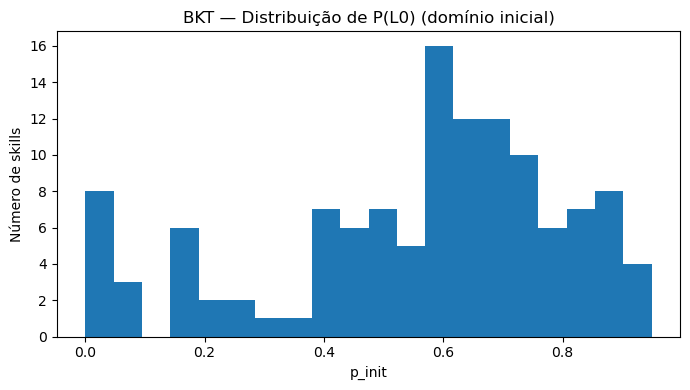

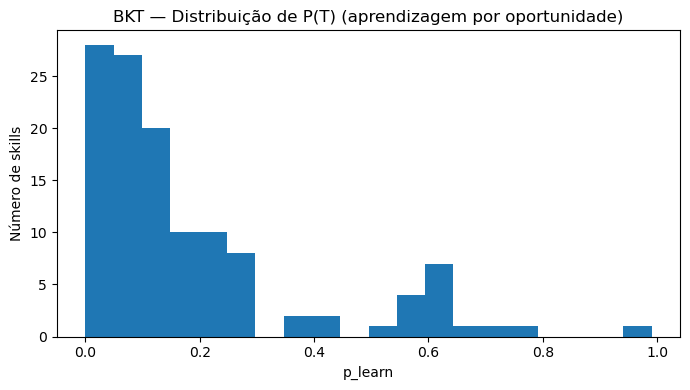

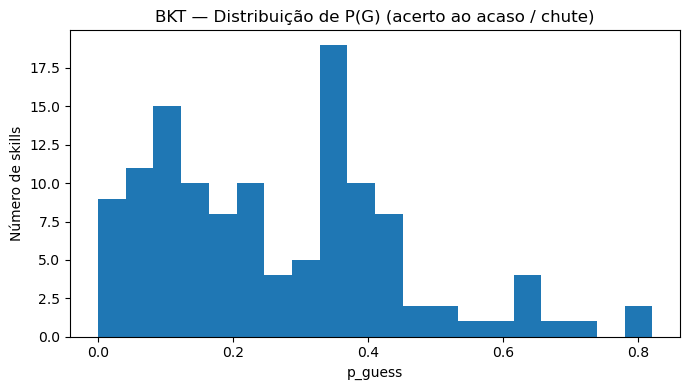

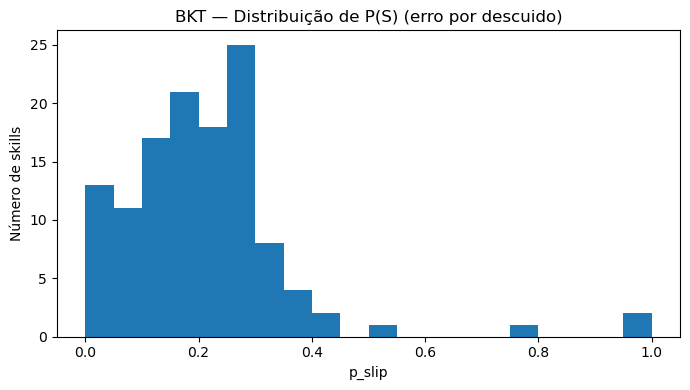

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# supondo que 'params' já foi criado na célula 1
rows = []
for sid, p in params.items():
    rows.append({
        "skill_id": sid,
        "p_init": p.p_init,
        "p_learn": p.p_learn,
        "p_guess": p.p_guess,
        "p_slip": p.p_slip,
        "p_correct_mastered": 1 - p.p_slip,
    })

param_df = pd.DataFrame(rows).sort_values("skill_id").reset_index(drop=True)
print(param_df.head())

def hist_param(df, col, title, bins=20):
    plt.figure(figsize=(7,4))
    plt.hist(df[col], bins=bins)
    plt.xlabel(col)
    plt.ylabel("Número de skills")
    plt.title(title)
    plt.tight_layout()
    plt.show()

hist_param(param_df, "p_init",  "BKT — Distribuição de P(L0) (domínio inicial)", bins=20)
hist_param(param_df, "p_learn", "BKT — Distribuição de P(T) (aprendizagem por oportunidade)", bins=20)
hist_param(param_df, "p_guess", "BKT — Distribuição de P(G) (acerto ao acaso / chute)", bins=20)
hist_param(param_df, "p_slip",  "BKT — Distribuição de P(S) (erro por descuido)", bins=20)


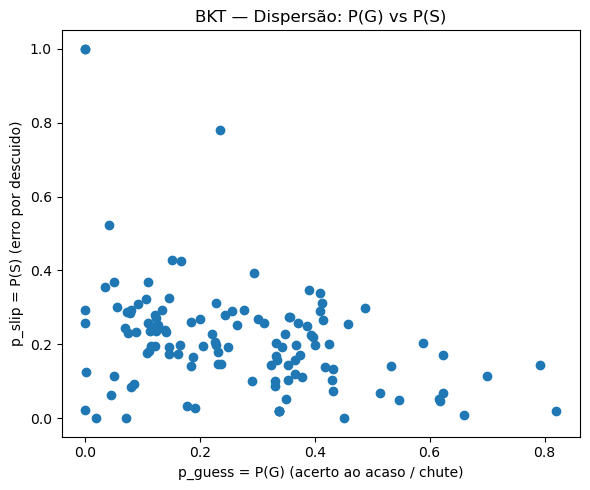

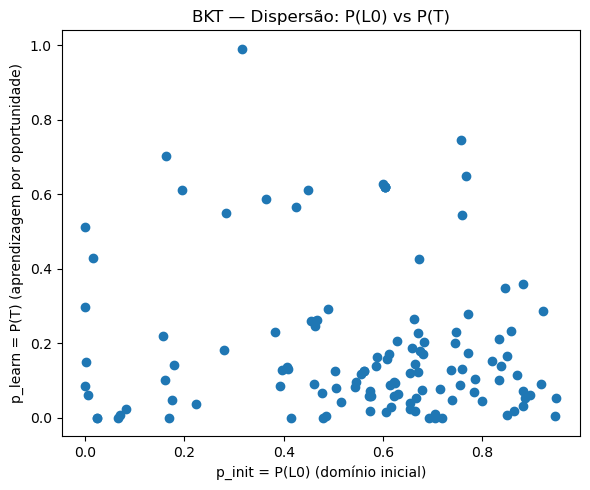

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
plt.scatter(param_df["p_guess"], param_df["p_slip"])
plt.xlabel("p_guess = P(G) (acerto ao acaso / chute)")
plt.ylabel("p_slip = P(S) (erro por descuido)")
plt.title("BKT — Dispersão: P(G) vs P(S)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,5))
plt.scatter(param_df["p_init"], param_df["p_learn"])
plt.xlabel("p_init = P(L0) (domínio inicial)")
plt.ylabel("p_learn = P(T) (aprendizagem por oportunidade)")
plt.title("BKT — Dispersão: P(L0) vs P(T)")
plt.tight_layout()
plt.show()

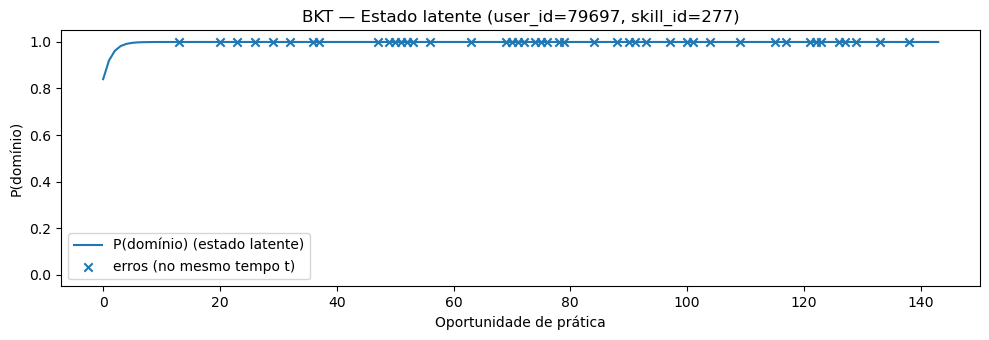

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

scored = pd.read_csv("assistments_bkt_scored.csv")

def plot_mastery_only(scored_df, user_id, skill_id, max_points=200):
    sub = scored_df[(scored_df["user_id"] == user_id) & (scored_df["skill_id"] == skill_id)].copy()
    sub = sub.sort_values("order_id").head(max_points)

    if sub.empty:
        print("Nenhuma interação para esse aluno/skill.")
        return

    x = range(len(sub))
    mastery = sub["p_mastery"].to_numpy()
    errors_x = [i for i, v in enumerate(sub["correct"].to_numpy()) if v == 0]

    plt.figure(figsize=(10,3.5))
    plt.plot(x, mastery, label="P(domínio) (estado latente)")
    plt.scatter(errors_x, [mastery[i] for i in errors_x], marker="x", label="erros (no mesmo tempo t)")
    plt.ylim(-0.05, 1.05)
    plt.xlabel("Oportunidade de prática")
    plt.ylabel("P(domínio)")
    plt.title(f"BKT — Estado latente (user_id={user_id}, skill_id={skill_id})")
    plt.legend()
    plt.tight_layout()
    plt.show()

# exemplo
plot_mastery_only(scored, user_id=79697, skill_id=277)


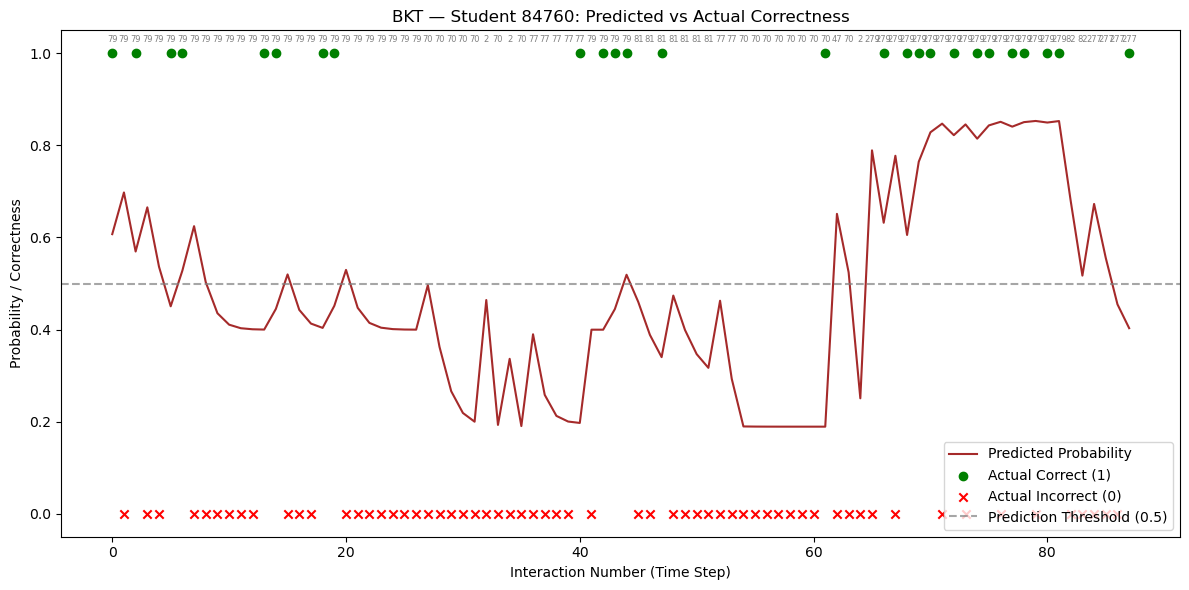

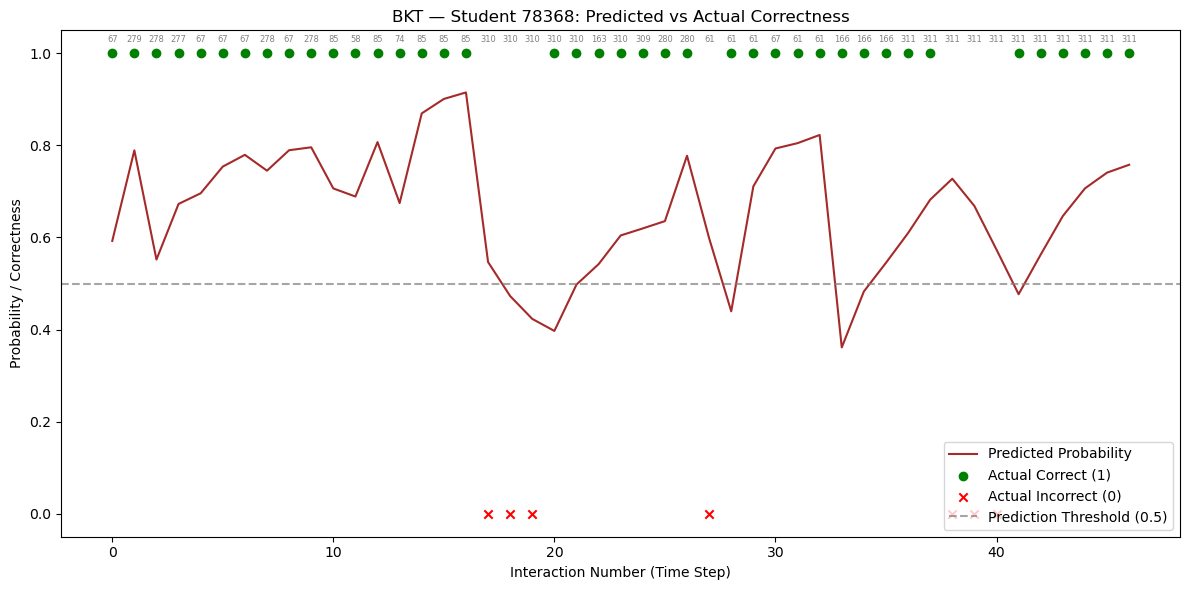

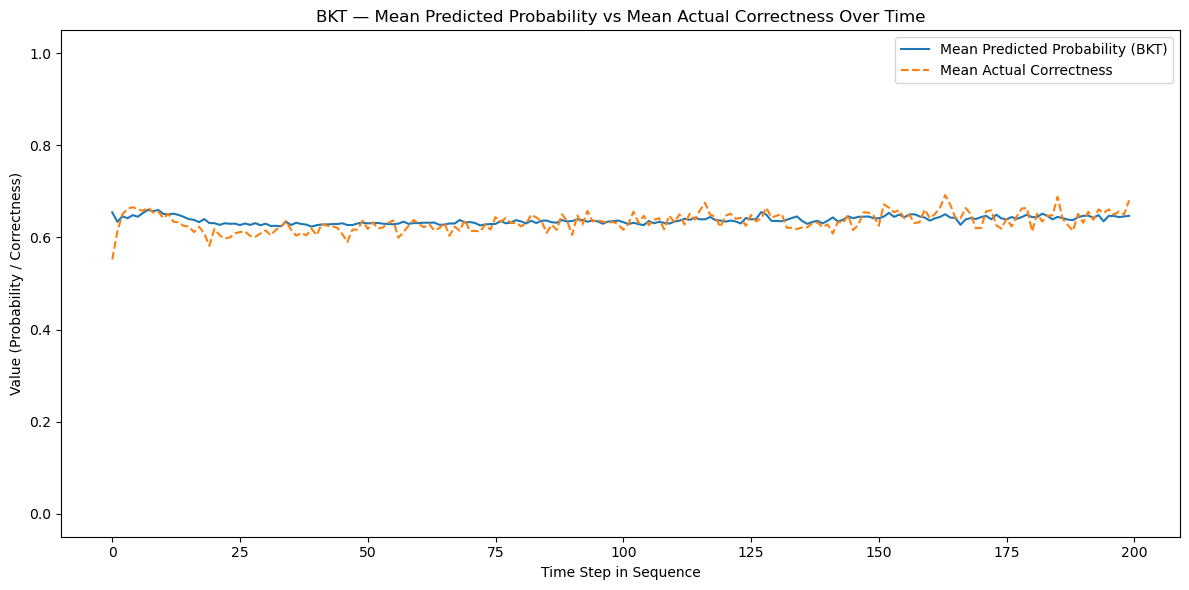

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

scored = pd.read_csv("assistments_bkt_scored.csv")


def plot_bkt_student(scored_df, user_id, threshold=0.5):
    sub = scored_df[scored_df["user_id"] == user_id].sort_values("order_id").copy()
    if sub.empty:
        print(f"Nenhuma interação para user_id={user_id}.")
        return

    T = len(sub)
    x = np.arange(T)

    plt.figure(figsize=(12, 6))

    plt.plot(x, sub["p_correct_next"].values,
             color="brown", label="Predicted Probability")

    correct_mask = sub["correct"] == 1
    incorrect_mask = ~correct_mask

    plt.scatter(x[correct_mask], np.ones(correct_mask.sum()),
                color="green", marker="o", label="Actual Correct (1)")
    plt.scatter(x[incorrect_mask], np.zeros(incorrect_mask.sum()),
                color="red", marker="x", label="Actual Incorrect (0)")

    plt.axhline(threshold, linestyle="--", color="gray",
                alpha=0.7, label="Prediction Threshold (0.5)")

    for i, sid in enumerate(sub["skill_id"].values):
        plt.text(i, 1.02, str(sid), ha="center", va="bottom",
                 fontsize=6, color="gray")

    plt.ylim(-0.05, 1.05)
    plt.xlabel("Interaction Number (Time Step)")
    plt.ylabel("Probability / Correctness")
    plt.title(f"BKT — Student {user_id}: Predicted vs Actual Correctness")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()


def plot_bkt_student_skill(scored_df, user_id, skill_id, threshold=0.5):
    sub = scored_df[
        (scored_df["user_id"] == user_id) &
        (scored_df["skill_id"] == skill_id)
    ].sort_values("order_id").copy()

    if sub.empty:
        print(f"Nenhuma interação para user_id={user_id}, skill_id={skill_id}.")
        return

    T = len(sub)
    x = np.arange(T)

    plt.figure(figsize=(12, 6))

    plt.plot(x, sub["p_correct_next"].values,
             color="blue",
             label=f"Predicted P(Correct) for Skill {skill_id}")

    correct_mask = sub["correct"] == 1
    incorrect_mask = ~correct_mask
    plt.scatter(x[correct_mask], np.ones(correct_mask.sum()),
                color="green", marker="o", alpha=0.4)
    plt.scatter(x[incorrect_mask], np.zeros(incorrect_mask.sum()),
                color="red", marker="x", alpha=0.4)

    plt.axhline(threshold, linestyle="--", color="gray",
                alpha=0.7, label="Prediction Threshold (0.5)")

    plt.ylim(-0.05, 1.05)
    plt.xlabel("Interaction Number (Time Step)")
    plt.ylabel("Probability / Correctness")
    plt.title(f"BKT — Student {user_id}, Skill {skill_id}: Predicted Probability Trajectory")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()


def plot_bkt_mean_over_time(scored_df, max_steps=200):
    df_sorted = scored_df.sort_values(["user_id", "order_id"]).copy()
    df_sorted["t_idx"] = df_sorted.groupby("user_id").cumcount()

    agg = (
        df_sorted[df_sorted["t_idx"] < max_steps]
        .groupby("t_idx")
        .agg(
            mean_pred=("p_correct_next", "mean"),
            mean_actual=("correct", "mean"),
        )
        .reset_index()
    )

    plt.figure(figsize=(12, 6))
    plt.plot(agg["t_idx"], agg["mean_pred"],
             label="Mean Predicted Probability (BKT)")
    plt.plot(agg["t_idx"], agg["mean_actual"],
             linestyle="--", label="Mean Actual Correctness")

    plt.xlabel("Time Step in Sequence")
    plt.ylabel("Value (Probability / Correctness)")
    plt.title("BKT — Mean Predicted Probability vs Mean Actual Correctness Over Time")
    plt.ylim(-0.05, 1.05)
    plt.legend()
    plt.tight_layout()
    plt.show()


# exemplos
plot_bkt_student(scored, user_id=84760)
plot_bkt_student(scored, user_id=78368)
plot_bkt_mean_over_time(scored, max_steps=200)

In [6]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score

# se df não estiver na memória, recarregue:
# df = prepare_bkt_dataframe(CSV_PATH)

rng = np.random.default_rng(seed=42)

all_users = df["user_id"].unique()
rng.shuffle(all_users)

train_frac = 0.8
n_train = int(len(all_users) * train_frac)

train_users = set(all_users[:n_train])
test_users  = set(all_users[n_train:])

train_df = df[df["user_id"].isin(train_users)].copy()
test_df  = df[df["user_id"].isin(test_users)].copy()

print(f"N usuários treino: {len(train_users)}")
print(f"N usuários teste : {len(test_users)}")
print(f"Interações treino: {len(train_df):,}")
print(f"Interações teste : {len(test_df):,}")

# treinar BKT para TODAS as skills presentes no treino
params_train = fit_bkt_for_skills(
    train_df,
    min_interactions_per_skill=1,  # <<< ANTES era 500
    n_iter=20,
    tol=1e-4
)
print(f"Total de skills treinadas (treino): {len(params_train)}")

# gerar previsões no conjunto de teste
scored_test = score_dataframe(test_df, params_train)
print(scored_test.head())

# AUC global (micro)
y_true = scored_test["correct"].to_numpy(dtype=int)
y_score = scored_test["p_correct_next"].to_numpy(dtype=float)
auc_global = roc_auc_score(y_true, y_score)
print(f"AUC BKT (teste, global): {auc_global:.4f}")

# AUC por skill (macro AUC)
auc_by_skill = {}
for sid, g in scored_test.groupby("skill_id"):
    y_true_k = g["correct"].to_numpy(dtype=int)
    y_score_k = g["p_correct_next"].to_numpy(dtype=float)
    if len(np.unique(y_true_k)) == 2:  # precisa ter pelo menos um 0 e um 1
        auc_by_skill[sid] = roc_auc_score(y_true_k, y_score_k)

print(f"N skills com AUC definido no teste: {len(auc_by_skill)}")
if auc_by_skill:
    macro_auc = np.mean(list(auc_by_skill.values()))
    print(f"Macro AUC (média por skill): {macro_auc:.4f}")


N usuários treino: 3330
N usuários teste : 833
Interações treino: 275,312
Interações teste : 62,689
[fit] Treinando BKT para 123 skills (min_interactions=1).
Total de skills treinadas (treino): 123
   order_id  user_id  problem_id  skill_id  correct  p_mastery  p_correct_next
0  33392795    70729       51454         1        0   0.496751        0.716109
1  33392817    70729       51460         1        1   0.740395        0.596993
2  33392838    70729       51425         1        0   0.494022        0.714903
3  33392907    70729       51468         1        1   0.738409        0.595672
4  33392928    70729       51400         1        1   0.887161        0.713942
AUC BKT (teste, global): 0.7214
N skills com AUC definido no teste: 111
Macro AUC (média por skill): 0.6440


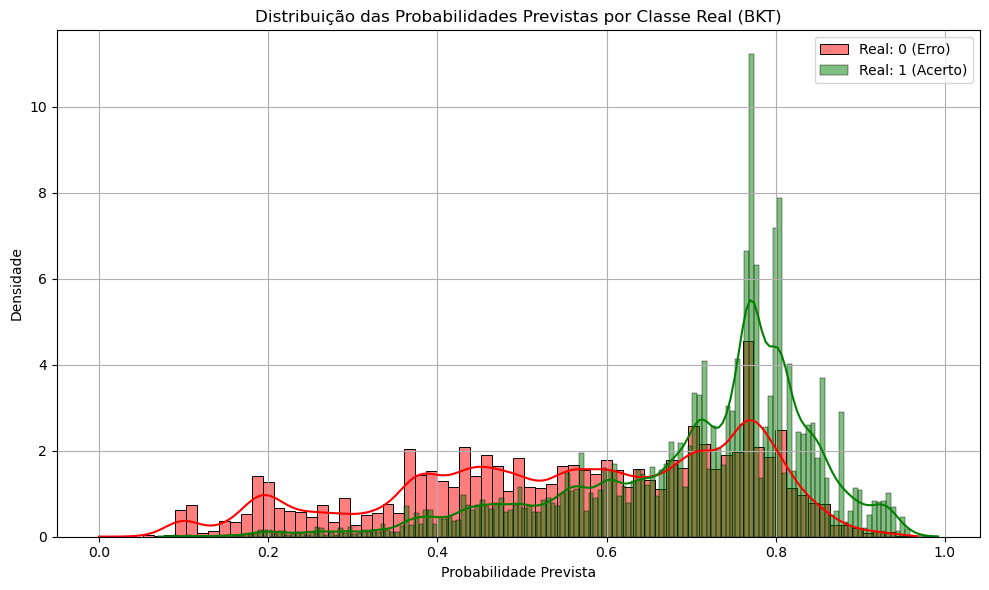

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


df = scored.copy()



y_pred = df["p_correct_next"].values
y_true = df["correct"].values

#Plot do histograma por classe real
plt.figure(figsize=(10, 6))

sns.histplot(y_pred[y_true == 0], 
             color='red', 
             label='Real: 0 (Erro)', 
             kde=True, 
             stat='density', 
             alpha=0.5)

sns.histplot(y_pred[y_true == 1], 
             color='green', 
             label='Real: 1 (Acerto)', 
             kde=True, 
             stat='density', 
             alpha=0.5)

plt.xlabel("Probabilidade Prevista")
plt.ylabel("Densidade")
plt.title("Distribuição das Probabilidades Previstas por Classe Real (BKT)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Arrays no roc_data (1).npz: ['y_true', 'y_pred']


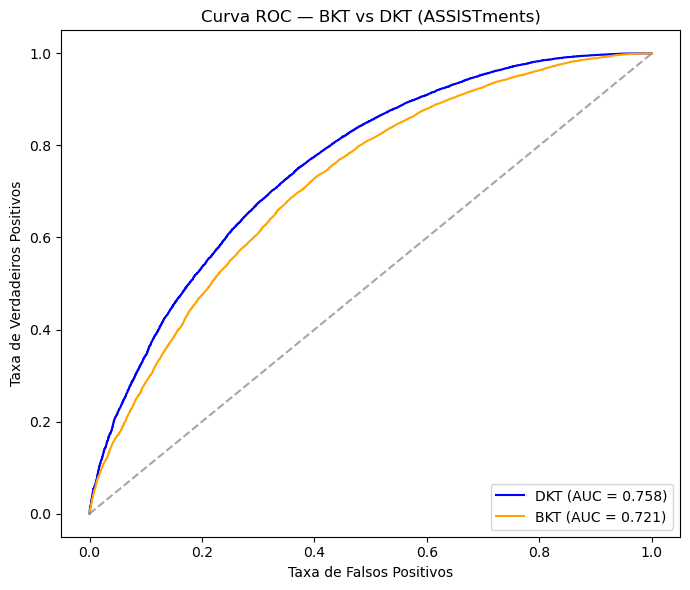

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score


#BKT: y_true e y_score (do seu scored_test)

y_true_bkt = scored_test["correct"].astype(int).to_numpy()
y_score_bkt = scored_test["p_correct_next"].astype(float).to_numpy()

fpr_bkt, tpr_bkt, _ = roc_curve(y_true_bkt, y_score_bkt)
auc_bkt = roc_auc_score(y_true_bkt, y_score_bkt)


#DKT: carregar do roc_data.npz

data = np.load(r"C:\Users\italo\Downloads\roc_data (1).npz")

print("Arrays no roc_data (1).npz:", data.files)
y_true_dkt = data["y_true"]
y_score_dkt = data["y_pred"]

fpr_dkt, tpr_dkt, _ = roc_curve(y_true_dkt, y_score_dkt)
auc_dkt = roc_auc_score(y_true_dkt, y_score_dkt)


#Plot comparativo

plt.figure(figsize=(7, 6))

# Agora invertido como você pediu:
plt.plot(fpr_dkt, tpr_dkt, color="blue", label=f"DKT (AUC = {auc_dkt:.3f})")
plt.plot(fpr_bkt, tpr_bkt, color="orange", label=f"BKT (AUC = {auc_bkt:.3f})")

plt.plot([0, 1], [0, 1], "--", color="gray", alpha=0.7)

plt.xlabel("Taxa de Falsos Positivos")
plt.ylabel("Taxa de Verdadeiros Positivos")
plt.title("Curva ROC — BKT vs DKT (ASSISTments)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, mean_squared_error, brier_score_loss

def plot_bkt_student_with_metrics(scored_df, user_id):
    sd = scored_df[scored_df["user_id"] == user_id].copy()
    if sd.empty:
        print(f"Nenhum dado encontrado para user_id={user_id}")
        return
    
    # ordena pela ordem cronológica do dataset
    sd = sd.sort_values("order_id")
    
    y_true = sd["correct"].values
    y_pred = sd["p_correct_next"].values
    
    auc = roc_auc_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    brier = brier_score_loss(y_true, y_pred)

    
    x = np.arange(len(sd))

    plt.figure(figsize=(12, 6))
    plt.plot(x, y_pred, label="Probabilidade Predita", color="brown")

    plt.scatter(x[y_true == 1], np.ones((y_true == 1).sum()),
                color="green", marker="o", label="Acerto Real (1)")
    plt.scatter(x[y_true == 0], np.zeros((y_true == 0).sum()),
                color="red", marker="x", label="Erro Real (0)")

    plt.axhline(0.5, color="gray", linestyle="--", label="Linha de Referência (0.5)")


    for i, sid in enumerate(sd["skill_id"].values):
        plt.text(i, 1.02, str(sid), ha="center", va="bottom", fontsize=6, color="gray")

    plt.title(
        f"Estudante {user_id}: Probabilidade Predita vs Resultado Real "
        f"(Métricas: AUC={auc:.2f}, RMSE={rmse:.2f}, Brier={brier:.2f})"
    )
    plt.xlabel("Interação (Time Step)")
    plt.ylabel("Probabilidade / Acerto")
    plt.ylim(-0.05, 1.05)
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()


def plot_bkt_student_skill(scored_df, user_id, skill_id):
    sd = scored_df[
        (scored_df["user_id"] == user_id) &
        (scored_df["skill_id"] == skill_id)
    ].copy()
    if sd.empty:
        print(f"Nenhum dado encontrado para user_id={user_id}, skill_id={skill_id}")
        return

    sd = sd.sort_values("order_id")
    y_true = sd["correct"].values
    y_pred = sd["p_correct_next"].values
    x = np.arange(len(sd))

    plt.figure(figsize=(12, 4))
    plt.plot(x, y_pred, label=f"Probabilidade Predita P(Acerto) — Habilidade {skill_id}", color="brown")

    plt.scatter(x[y_true == 1], np.ones((y_true == 1).sum()),
                color="green", marker="o", alpha=0.4, label="Acerto (1)")
    plt.scatter(x[y_true == 0], np.zeros((y_true == 0).sum()),
                color="red", marker="x", alpha=0.4, label="Erro (0)")

    plt.axhline(0.5, color="gray", linestyle="--", label="Linha de Referência (0.5)")
    plt.ylim(-0.05, 1.05)
    plt.xlabel("Interação")
    plt.ylabel("Probabilidade / Acerto")
    plt.title(f"Estudante {user_id}, Habilidade {skill_id}: Probabilidade Predita (BKT)")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()


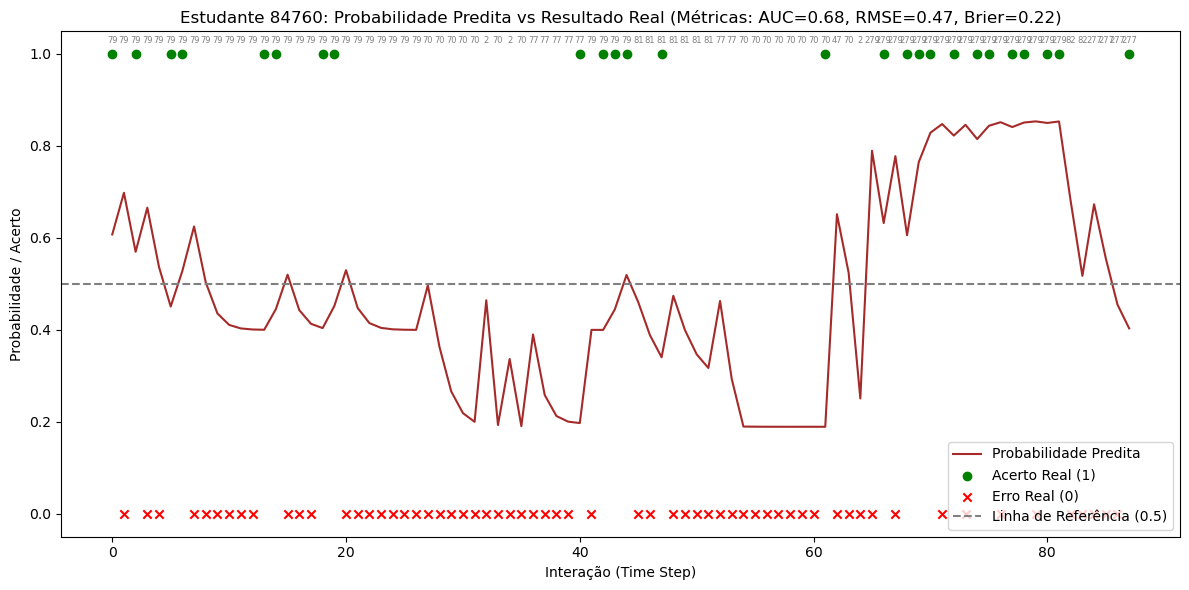

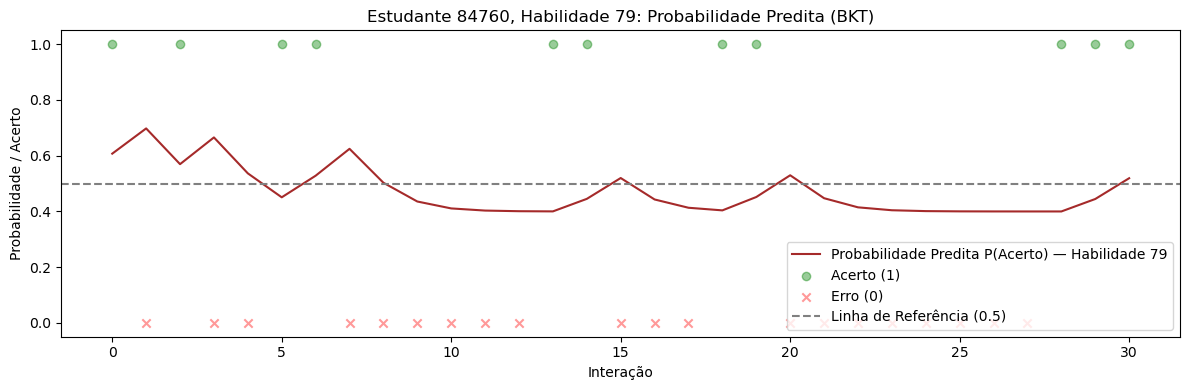

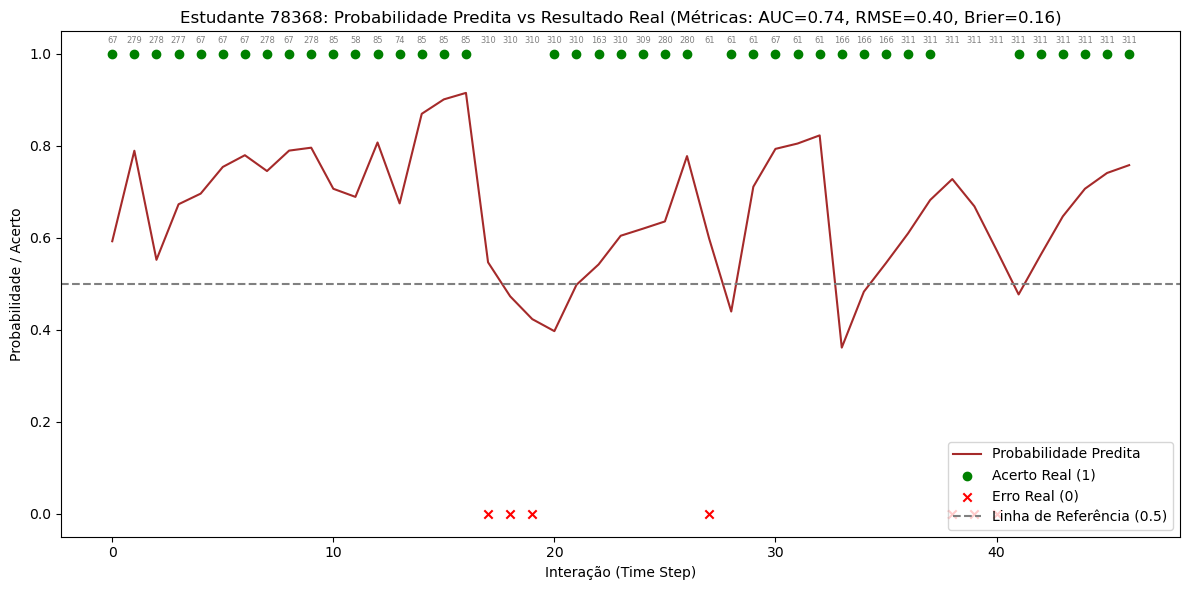

In [17]:
# Student 84760 
plot_bkt_student_with_metrics(scored, user_id=84760)

# Student 84760, skill 79
plot_bkt_student_skill(scored, user_id=84760, skill_id=79)

# Student 78368 
plot_bkt_student_with_metrics(scored, user_id=78368)


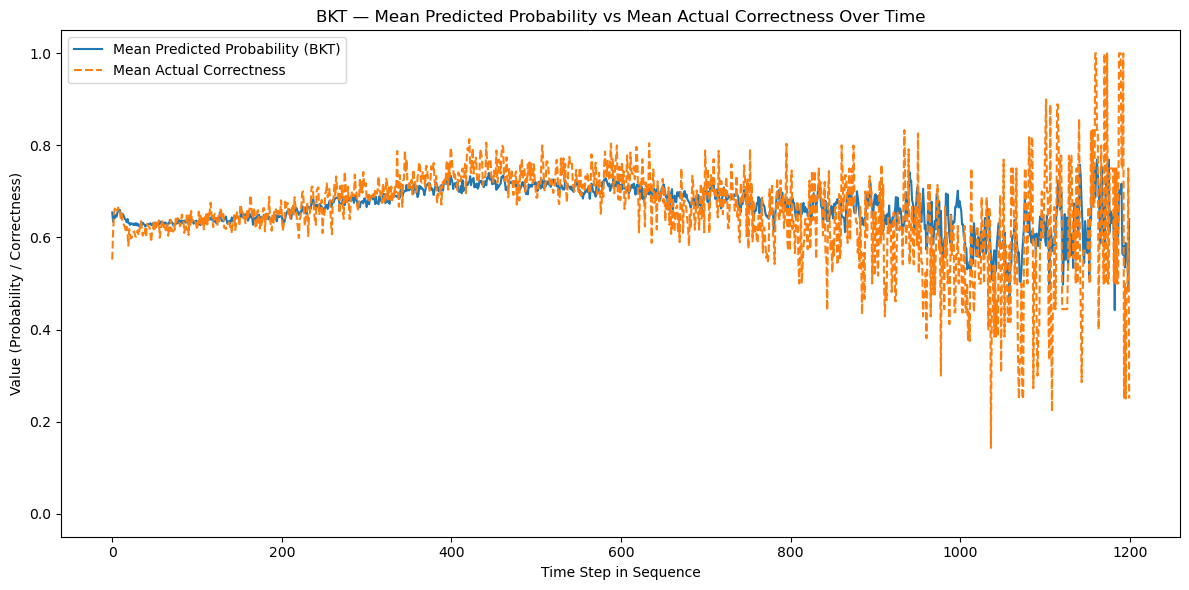

In [11]:


plot_bkt_mean_over_time(scored, max_steps=1200)


Estudante 84760 (todas as habilidades):


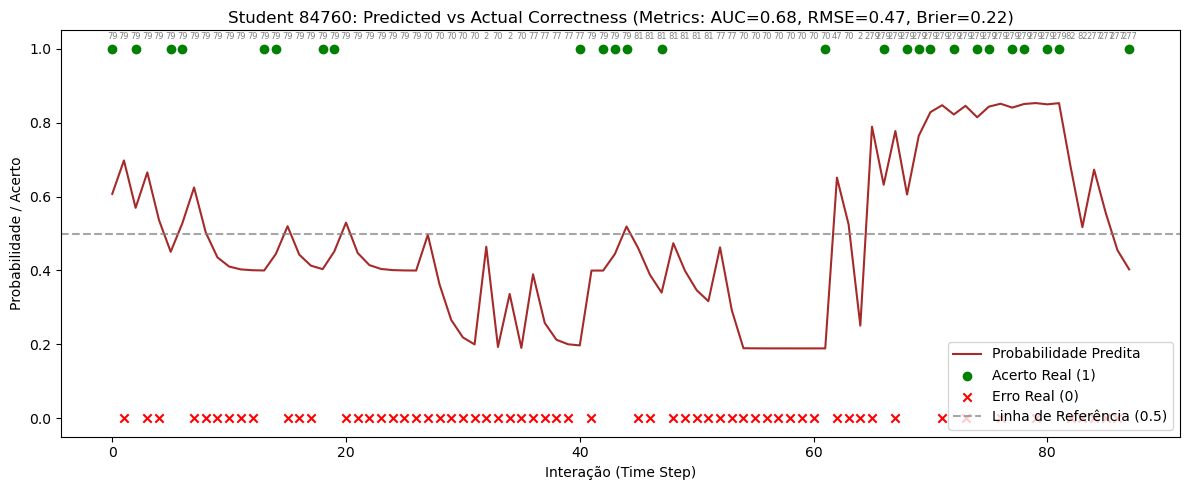

Estudante 84760 — Habilidade 79:


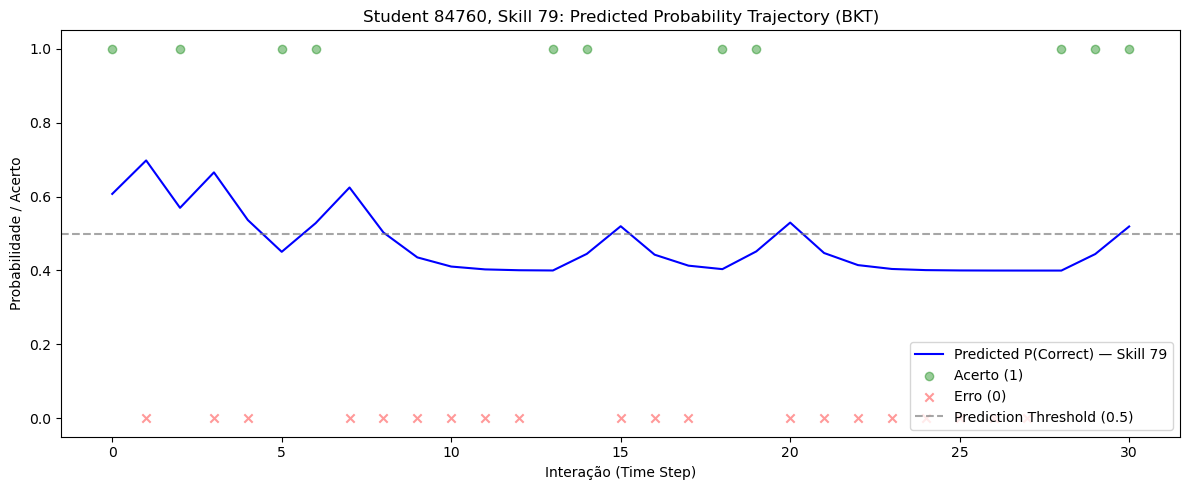

Estudante 81656 (todas as skills):


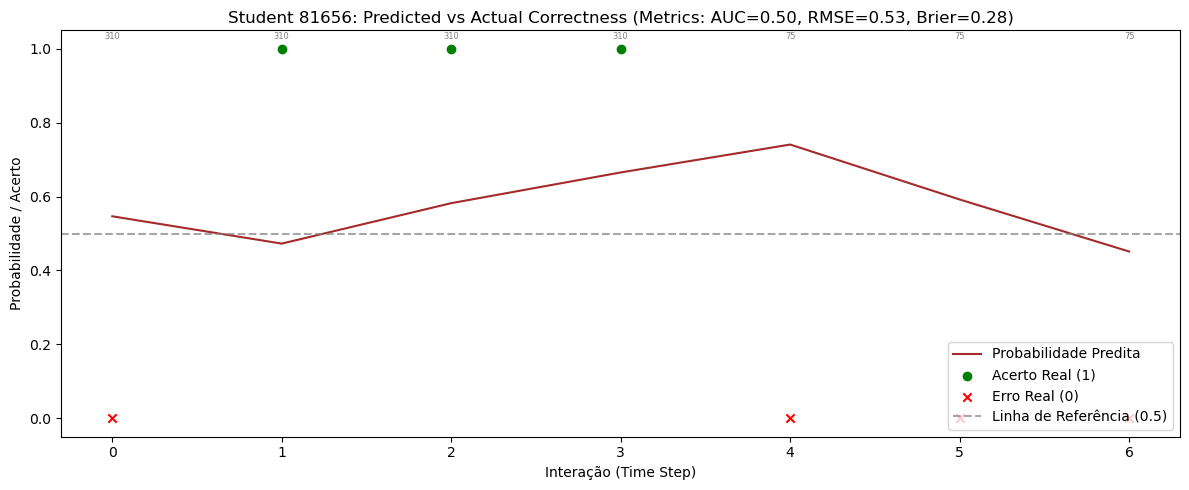

Estudante 81656 — Habilidade 295:


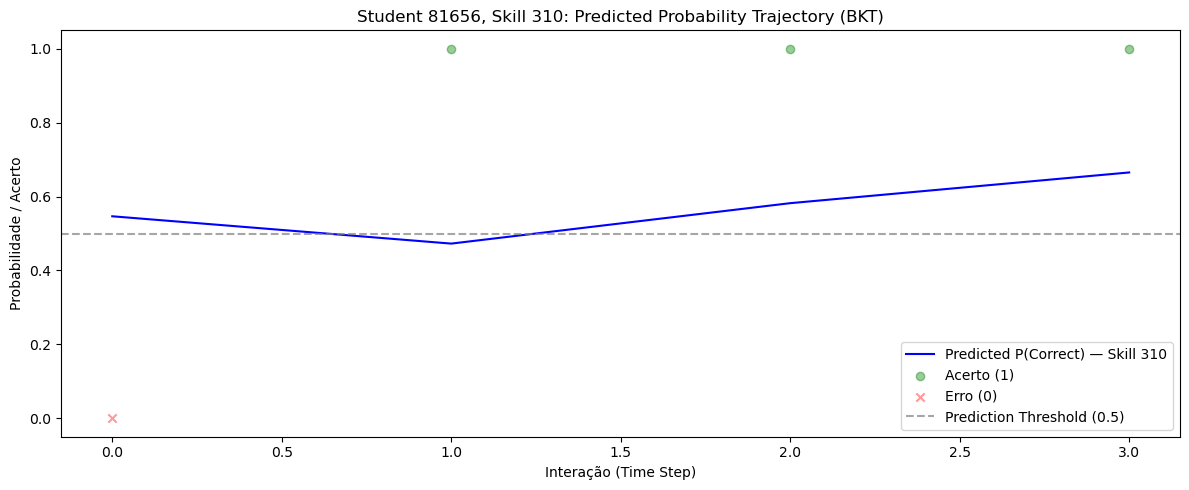

Estudante 78027 (todas as habilidades):


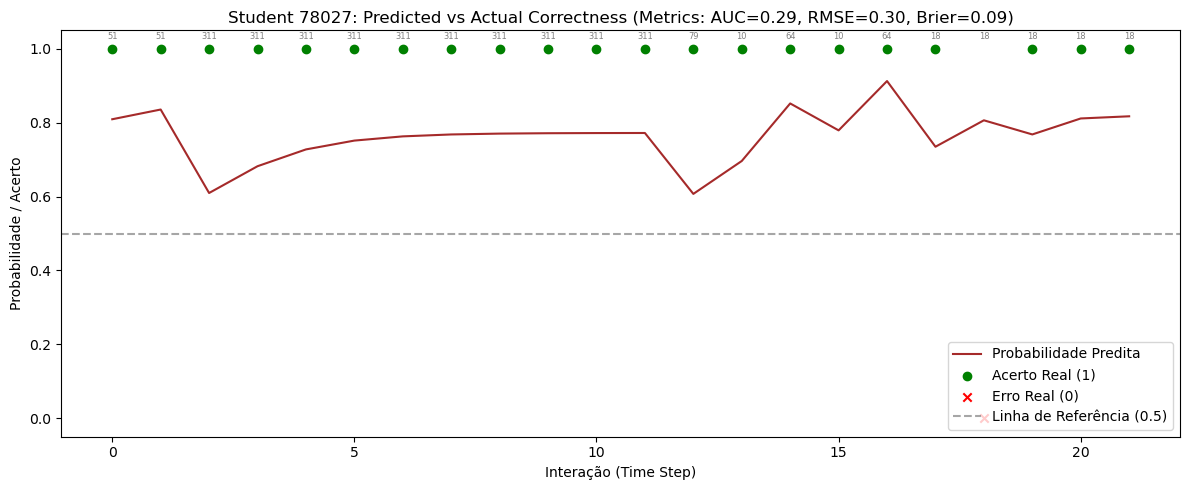

Estudante 78027 — Habilidade 18:


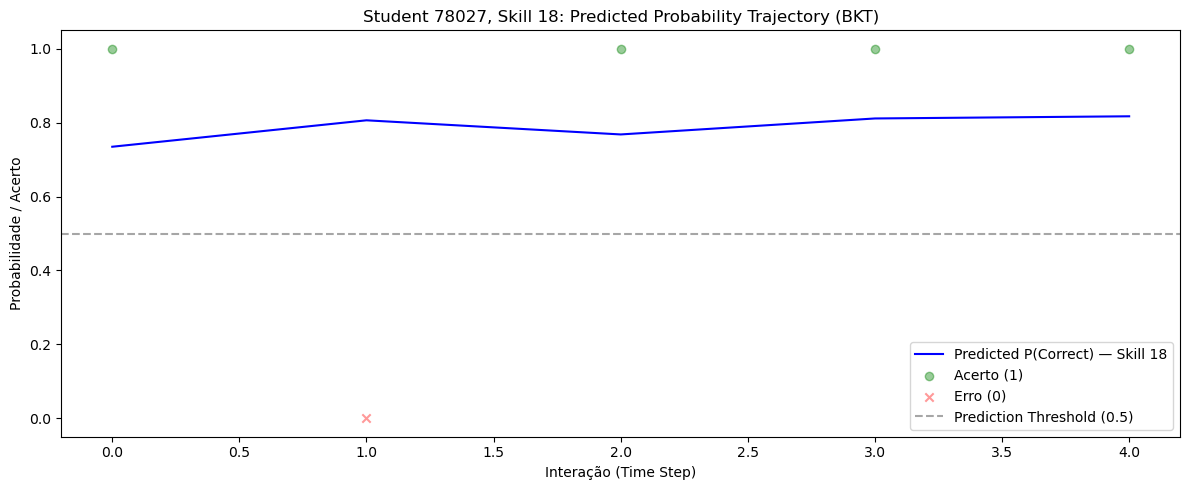

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, brier_score_loss


#Função de métricas por aluno


def compute_student_metrics(scored_df, user_id):
    sd = scored_df[scored_df["user_id"] == user_id].copy()
    if sd.empty:
        print(f"Nenhum dado encontrado para user_id={user_id}")
        return None
    
    sd = sd.sort_values("order_id")
    y_true = sd["correct"].astype(int).values
    y_pred = sd["p_correct_next"].astype(float).values

    # AUC só faz sentido se tiver pelo menos um 0 e um 1
    if len(np.unique(y_true)) < 2:
        auc = np.nan
    else:
        auc = roc_auc_score(y_true, y_pred)
    
    
    rmse = float(np.sqrt(np.mean((y_true - y_pred) ** 2)))
    brier = float(brier_score_loss(y_true, y_pred))

    return {
        "user_id": user_id,
        "auc": auc,
        "rmse": rmse,
        "brier": brier,
        "n": len(sd),
    }


#Gráfico por aluno (todas as skills)


def plot_bkt_student_with_metrics(scored_df, user_id, threshold=0.5):
    metrics = compute_student_metrics(scored_df, user_id)
    if metrics is None:
        return

    sd = scored_df[scored_df["user_id"] == user_id].copy()
    sd = sd.sort_values("order_id")

    x = np.arange(len(sd))
    y_pred = sd["p_correct_next"].values
    y_true = sd["correct"].values

    plt.figure(figsize=(12, 5))

    # linha de probabilidade prevista
    plt.plot(x, y_pred, color="brown", label="Probabilidade Predita")

    # acertos e erros reais
    correct_mask = y_true == 1
    incorrect_mask = ~correct_mask

    plt.scatter(x[correct_mask], np.ones(correct_mask.sum()),
                color="green", marker="o", label="Acerto Real (1)")
    plt.scatter(x[incorrect_mask], np.zeros(incorrect_mask.sum()),
                color="red", marker="x", label="Erro Real (0)")

    # linha de threshold
    plt.axhline(threshold, linestyle="--", color="gray",
                alpha=0.7, label=f"Linha de Referência ({threshold})")

    # anotar skill_id em cima dos acertos (igual DKT)
    for i, sid in enumerate(sd["skill_id"].values):
        plt.text(i, 1.02, str(sid), ha="center", va="bottom",
                 fontsize=6, color="gray")

    auc_str = "nan" if np.isnan(metrics["auc"]) else f"{metrics['auc']:.2f}"
    plt.title(
        f"Student {user_id}: Predicted vs Actual Correctness "
        f"(Metrics: AUC={auc_str}, RMSE={metrics['rmse']:.2f}, Brier={metrics['brier']:.2f})"
    )

    plt.ylim(-0.05, 1.05)
    plt.xlabel("Interação (Time Step)")
    plt.ylabel("Probabilidade / Acerto")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()


#Gráfico por aluno + skill específica


def plot_bkt_student_skill(scored_df, user_id, skill_id, threshold=0.5):
    sd = scored_df[
        (scored_df["user_id"] == user_id) &
        (scored_df["skill_id"] == skill_id)
    ].copy()

    if sd.empty:
        print(f"Nenhum dado para user_id={user_id}, skill_id={skill_id}")
        return

    sd = sd.sort_values("order_id")
    x = np.arange(len(sd))
    y_pred = sd["p_correct_next"].values
    y_true = sd["correct"].values

    plt.figure(figsize=(12, 5))

    plt.plot(x, y_pred, color="blue",
             label=f"Predicted P(Correct) — Skill {skill_id}")

    correct_mask = y_true == 1
    incorrect_mask = ~correct_mask

    plt.scatter(x[correct_mask], np.ones(correct_mask.sum()),
                color="green", marker="o", alpha=0.4, label="Acerto (1)")
    plt.scatter(x[incorrect_mask], np.zeros(incorrect_mask.sum()),
                color="red", marker="x", alpha=0.4, label="Erro (0)")

    plt.axhline(threshold, linestyle="--", color="gray",
                alpha=0.7, label=f"Prediction Threshold ({threshold})")

    plt.ylim(-0.05, 1.05)
    plt.xlabel("Interação (Time Step)")
    plt.ylabel("Probabilidade / Acerto")
    plt.title(f"Student {user_id}, Skill {skill_id}: Predicted Probability Trajectory (BKT)")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()




print("Estudante 84760 (todas as habilidades):")
plot_bkt_student_with_metrics(scored, user_id=84760)

print("Estudante 84760 — Habilidade 79:")
plot_bkt_student_skill(scored, user_id=84760, skill_id=79)

print("Estudante 81656 (todas as skills):")
plot_bkt_student_with_metrics(scored, user_id=81656)

print("Estudante 81656 — Habilidade 295:")
plot_bkt_student_skill(scored, user_id=81656, skill_id=310)

print("Estudante 78027 (todas as habilidades):")
plot_bkt_student_with_metrics(scored, user_id=78027)

print("Estudante 78027 — Habilidade 18:")
plot_bkt_student_skill(scored, user_id=78027, skill_id=18)




In [13]:
aluno = 78027

sub_78027 = scored[scored["user_id"] == aluno].copy()
print("N interações do aluno:", len(sub_78027))
print("Skills do aluno no scored:")
print(sub_78027["skill_id"].value_counts())


N interações do aluno: 22
Skills do aluno no scored:
skill_id
311    10
18      5
10      2
51      2
64      2
79      1
Name: count, dtype: int64
